# Тематическое моделироание
#### Пользуемся библиотекой artm, тут инструкция по установке и гайды https://bigartm.readthedocs.io/en/stable/index.html

In [1]:
import glob
import os
import matplotlib.pyplot as plt
import numpy
import artm 
import warnings; warnings.simplefilter('ignore')

#### Будем использовать набор данных kos, который также можно найти по ссылке выше.
#### Набор содержит 3430 документов, 6906 слов в словаре, 353160 ненулевых счётчиков в "мешке слов". Удалены слова, встречающиеся менее 10 раз. Разобьем коллекцию на тренировочную и тестовую в соотношении 3000:430.

#### Преобразуем данные в батчи, сохраняем их в папке kos_train, чтобы впоследствии сразу их считывать

In [2]:
batch_vectorizer = None
if len(glob.glob(os.path.join('kos_train', '*.batch'))) < 1:
    batch_vectorizer = artm.BatchVectorizer(data_path='', data_format='bow_uci',
                                            collection_name='kos_train', target_folder='kos_train')
else:
    batch_vectorizer = artm.BatchVectorizer(data_path='kos_train', data_format='batches')

#### Инициализируем словар, соберем его из созданных батчей и сохраним в папку с батчами.

In [3]:
dictionary = artm.Dictionary()
if not os.path.isfile('kos_train/dictionary.dict'):
    dictionary.gather(data_path=batch_vectorizer.data_path)
    dictionary.save(dictionary_path='kos_train/dictionary.dict')
dictionary.load(dictionary_path='kos_train/dictionary.dict')

#### Модель требует выбора числа тем, положим его 20, зададим имена тем.

#### Далее инициализируем классическую модель и модель ARTM, добавим к ним критерии качества: перплексия, разреженность матриц Фи и Тэта и характеристики ядер тем.
#### На данном этапе подключим к модели ARTM регуляризаторы сглаживания фоновых тем в обеих матрицах и регулизатор декоррелирования тем в матрице Фи, также разделенный по типу тем. Коэффициенты взяты примерно такие, как в примерах из этой библиотеки.

In [4]:
topic_names = ['topic_{}'.format(i) for i in range(20)]

model_plsa = artm.ARTM(topic_names=topic_names, cache_theta=True,
                       scores=[artm.PerplexityScore(name='PerplexityScore', dictionary=dictionary),
                               artm.SparsityPhiScore(name='SparsityPhiScore'),
                               artm.SparsityThetaScore(name='SparsityThetaScore'),
                               artm.TopicKernelScore(name='TopicKernelScore', probability_mass_threshold=0.25)])

model_artm = artm.ARTM(topic_names=topic_names, cache_theta=True,
                       scores=[artm.PerplexityScore(name='PerplexityScore', dictionary=dictionary),
                               artm.SparsityPhiScore(name='SparsityPhiS', topic_names=topic_names[0:18]),
                               artm.SparsityPhiScore(name='SparsityPhiB', topic_names=topic_names[18:20]),
                               artm.SparsityThetaScore(name='SparsityThetaS', topic_names=topic_names[0:18]),
                               artm.SparsityThetaScore(name='SparsityThetaB', topic_names=topic_names[18:20]),
                               artm.TopicKernelScore(name='TopicKernelScore', probability_mass_threshold=0.25)],
                       regularizers=[artm.SmoothSparseThetaRegularizer(name='SparseThetaB', tau=0.15, 
                                                                       topic_names=topic_names[18:20]),
                                     artm.SmoothSparsePhiRegularizer(name='SparsePhiB', tau=0.15,
                                                                     topic_names=topic_names[18:20]),
                                     artm.DecorrelatorPhiRegularizer(name='DecorrelatorPhiB', tau=1e+5,
                                                                     topic_names=topic_names[18:20]),
                                     artm.DecorrelatorPhiRegularizer(name='DecorrelatorPhiS', tau=2e+5,
                                                                     topic_names=topic_names[0:17])])

#### Проинициализируем матрицы Фи и Тэта и начнем обучение модели, сделав 20 проходов

In [5]:
model_plsa.num_document_passes=1
model_artm.num_document_passes=1

model_plsa.initialize(dictionary=dictionary)
model_artm.initialize(dictionary=dictionary)

model_plsa.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=20)
model_artm.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=20)

#### Добавим регуляризатор разреживания предметных тем:

In [6]:
model_artm.regularizers.add(artm.SmoothSparseThetaRegularizer(name='SparseThetaS', tau=-0.2, topic_names=topic_names[0:18]))
model_artm.regularizers.add(artm.SmoothSparsePhiRegularizer(name='SparsePhiS', tau=-0.2, topic_names=topic_names[0:18]))

#### Подключим функционал, позволяющий взглянуть на самые вероятные слова в каждой теме:

In [7]:
model_plsa.scores.add(artm.TopTokensScore(name='TopTokensScore', num_tokens=6))
model_artm.scores.add(artm.TopTokensScore(name='TopTokensScore', num_tokens=6))

#### Продолжим обучение моделей, инициировав 25 проходов по коллекции

In [8]:
model_plsa.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=30)
model_artm.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=30)

#### Выведем заданные критерии качества и график изменения перплексии для обеих моделей

Sparsity Phi: 0.200 (PLSA) vs. 0.000 (ARTM B) and 0.887 (ARTM S)
Sparsity Theta: 0.000 (PLSA) vs. 0.000 (ARTM B) and 0.046 (ARTM S)
Kernel size: 449.050 (PLSA) vs. 266.500 (ARTM B) and 468.333 (ARTM S)
Kernel purity: 0.737 (PLSA) vs. 0.854 (ARTM)
Kernel contrast: 0.603 (PLSA) vs. 0.570 (ARTM B) and 0.676 (ARTM S)
Perplexity: 1508.167 (PLSA) vs. 1510.633 (ARTM)


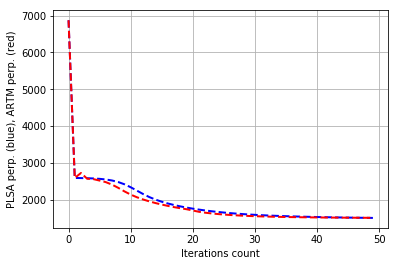

In [9]:
def print_measures(model_plsa, model_artm):
    print('Sparsity Phi: {0:.3f} (PLSA) vs. {1:.3f} (ARTM B) and {2:.3f} (ARTM S)'.format(
        model_plsa.score_tracker['SparsityPhiScore'].last_value,
        model_artm.score_tracker['SparsityPhiB'].last_value,
        model_artm.score_tracker['SparsityPhiS'].last_value))

    print('Sparsity Theta: {0:.3f} (PLSA) vs. {1:.3f} (ARTM B) and {2:.3f} (ARTM S)'.format(
        model_plsa.score_tracker['SparsityThetaScore'].last_value,
        model_artm.score_tracker['SparsityThetaB'].last_value,
        model_artm.score_tracker['SparsityThetaS'].last_value))

    print('Kernel size: {0:.3f} (PLSA) vs. {1:.3f} (ARTM B) and {2:.3f} (ARTM S)'.format(
        model_plsa.score_tracker['TopicKernelScore'].last_average_size,
        numpy.mean(list(model_artm.score_tracker['TopicKernelScore'].last_size.values())[18:20]),
        numpy.mean(list(model_artm.score_tracker['TopicKernelScore'].last_size.values())[0:18])))
    
    print('Kernel purity: {0:.3f} (PLSA) vs. {1:.3f} (ARTM)'.format(
        model_plsa.score_tracker['TopicKernelScore'].last_average_purity,
        model_artm.score_tracker['TopicKernelScore'].last_average_purity))

    print('Kernel contrast: {0:.3f} (PLSA) vs. {1:.3f} (ARTM B) and {2:.3f} (ARTM S)'.format(
        model_plsa.score_tracker['TopicKernelScore'].last_average_contrast,
        numpy.mean(list(model_artm.score_tracker['TopicKernelScore'].last_contrast.values())[18:20]),
        numpy.mean(list(model_artm.score_tracker['TopicKernelScore'].last_contrast.values())[0:18])))

    print('Perplexity: {0:.3f} (PLSA) vs. {1:.3f} (ARTM)'.format(
        model_plsa.score_tracker['PerplexityScore'].last_value,
        model_artm.score_tracker['PerplexityScore'].last_value))

print_measures(model_plsa, model_artm)
    
plt.plot(range(model_plsa.num_phi_updates),
         model_plsa.score_tracker['PerplexityScore'].value, 'b--',
         range(model_artm.num_phi_updates),
         model_artm.score_tracker['PerplexityScore'].value, 'r--', linewidth=2)
plt.xlabel('Iterations count')
plt.ylabel('PLSA perp. (blue), ARTM perp. (red)')
plt.grid(True)
plt.show()

#### Построим графики изменения разреженностей матриц по итерациям:

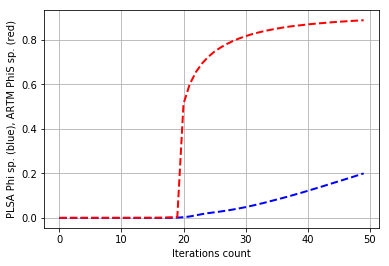

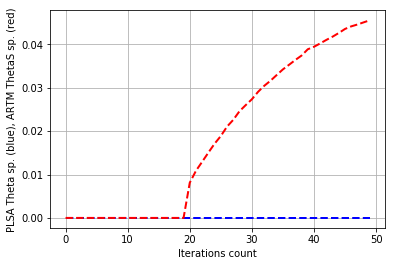

In [10]:
plt.plot(range(model_plsa.num_phi_updates),
         model_plsa.score_tracker['SparsityPhiScore'].value, 'b--',
         range(model_artm.num_phi_updates),
         model_artm.score_tracker['SparsityPhiS'].value, 'r--', linewidth=2)

plt.xlabel('Iterations count')
plt.ylabel('PLSA Phi sp. (blue), ARTM PhiS sp. (red)')
plt.grid(True)
plt.show()

plt.plot(range(model_plsa.num_phi_updates),
         model_plsa.score_tracker['SparsityThetaScore'].value, 'b--',
         range(model_artm.num_phi_updates),
         model_artm.score_tracker['SparsityThetaS'].value, 'r--', linewidth=2)

plt.xlabel('Iterations count')
plt.ylabel('PLSA Theta sp. (blue), ARTM ThetaS sp. (red)')
plt.grid(True)
plt.show()

#### При малых потерях перплексии удалось значительно разредить матрицу Фи
#### Продолжим обучение модели,  увеличив коэффициенты регуляризации для разреживания и декорреляции

In [11]:
model_artm.regularizers['SparseThetaS'].tau=-5
model_artm.regularizers['SparsePhiS'].tau=-0.5
model_artm.regularizers['DecorrelatorPhiS'].tau = 5e+5
model_artm.regularizers['SparseThetaB'].tau=0.5
model_artm.regularizers['SparsePhiB'].tau=0.5
model_artm.regularizers['DecorrelatorPhiB'].tau = 2.5e+5

model_plsa.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=50)
model_artm.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=50)

print_measures(model_plsa, model_artm)

Sparsity Phi: 0.518 (PLSA) vs. 0.000 (ARTM B) and 0.911 (ARTM S)
Sparsity Theta: 0.000 (PLSA) vs. 0.000 (ARTM B) and 0.627 (ARTM S)
Kernel size: 463.400 (PLSA) vs. 1183.500 (ARTM B) and 410.778 (ARTM S)
Kernel purity: 0.790 (PLSA) vs. 0.808 (ARTM)
Kernel contrast: 0.614 (PLSA) vs. 0.430 (ARTM B) and 0.573 (ARTM S)
Perplexity: 1468.447 (PLSA) vs. 1545.191 (ARTM)


#### Построим графики изменения разреженностей матриц по итерациям:

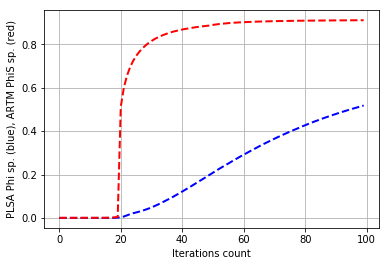

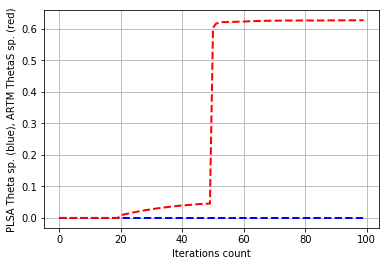

In [12]:
plt.plot(range(model_plsa.num_phi_updates),
         model_plsa.score_tracker['SparsityPhiScore'].value, 'b--',
         range(model_artm.num_phi_updates),
         model_artm.score_tracker['SparsityPhiS'].value, 'r--', linewidth=2)

plt.xlabel('Iterations count')
plt.ylabel('PLSA Phi sp. (blue), ARTM PhiS sp. (red)')
plt.grid(True)
plt.show()

plt.plot(range(model_plsa.num_phi_updates),
         model_plsa.score_tracker['SparsityThetaScore'].value, 'b--',
         range(model_artm.num_phi_updates),
         model_artm.score_tracker['SparsityThetaS'].value, 'r--', linewidth=2)

plt.xlabel('Iterations count')
plt.ylabel('PLSA Theta sp. (blue), ARTM ThetaS sp. (red)')
plt.grid(True)
plt.show()

#### Взглянем на топ-слова слова моделей:

In [13]:
for topic_name in model_plsa.topic_names:
    print(topic_name + ': ', model_plsa.score_tracker['TopTokensScore'].last_tokens[topic_name])

topic_0:  ['year', 'tax', 'jobs', 'years', 'plan', 'economy']
topic_1:  ['people', 'americans', 'country', 'american', 'continue', 'nations']
topic_2:  ['november', 'electoral', 'account', 'governor', 'contact', 'experience']
topic_3:  ['senate', 'conservative', 'senator', 'sen', 'bill', 'liberal']
topic_4:  ['time', 'ive', 'real', 'put', 'lot', 'isnt']
topic_5:  ['people', 'america', 'meteor', 'blades', 'convention', 'politics']
topic_6:  ['race', 'elections', 'candidate', 'district', 'seat', 'candidates']
topic_7:  ['white', 'administration', 'report', 'officials', 'security', 'intelligence']
topic_8:  ['campaign', 'party', 'political', 'ads', 'support', 'message']
topic_9:  ['house', 'million', 'money', 'committee', 'delay', 'congress']
topic_10:  ['senate', 'vote', 'election', 'house', 'republicans', 'general']
topic_11:  ['iraq', 'war', 'military', 'iraqi', 'american', 'troops']
topic_12:  ['bush', 'voters', 'general', 'nader', 'polling', 'news']
topic_13:  ['media', 'news', 'tom'

In [14]:
for topic_name in model_artm.topic_names:
    print(topic_name + ': ', model_artm.score_tracker['TopTokensScore'].last_tokens[topic_name])

topic_0:  ['party', 'tax', 'law', 'federal', 'health', 'court']
topic_1:  ['officials', 'united', 'official', 'information', 'leaders', 'nations']
topic_2:  ['electoral', 'account', 'poll', 'governor', 'polls', 'contact']
topic_3:  ['media', 'debate', 'tom', 'lot', 'ive', 'talking']
topic_4:  ['country', 'question', 'put', 'isnt', 'end', 'decision']
topic_5:  ['president', 'john', 'cheney', 'america', 'george', 'politics']
topic_6:  ['percent', 'state', 'nader', 'votes', 'ballot', 'presidential']
topic_7:  ['administration', 'white', 'report', 'government', 'jobs', 'commission']
topic_8:  ['dean', 'campaign', 'iowa', 'candidates', 'deans', 'union']
topic_9:  ['money', 'million', 'committee', 'delay', 'raised', 'ads']
topic_10:  ['senate', 'house', 'race', 'republicans', 'democratic', 'elections']
topic_11:  ['iraq', 'war', 'military', 'iraqi', 'american', 'troops']
topic_12:  ['republican', 'democrats', 'states', 'election', 'voters', 'vote']
topic_13:  ['time', 'long', 'washington', '

#### Посмотрим на перплексию тестовой выборки
#### Для этого сконвертируем в батчи тестовую коллекцию и применим метод transform. Он возвращает матрицу Тэта новой коллекции

In [15]:
test_batch_vectorizer = None
if len(glob.glob(os.path.join('kos_test', '*.batch'))) < 1:
    test_batch_vectorizer = artm.BatchVectorizer(data_path='', data_format='bow_uci',
                                            collection_name='kos_test', target_folder='kos_test')
else:
    test_batch_vectorizer = artm.BatchVectorizer(data_path='kos_test', data_format='batches')

model_plsa.transform(batch_vectorizer=test_batch_vectorizer)

,3001,3002,3003,3004,3005,3006,3007,3008,3009,3010,...,3421,3422,3423,3424,3425,3426,3427,3428,3429,3430
topic_0,0.051867,0.046510,0.018661,0.025743,0.035275,0.010974,0.030683,0.013324,0.034340,0.029558,...,0.012893,0.020713,0.019298,0.014391,0.028082,0.055648,0.105677,0.124944,0.064337,0.023716
topic_1,0.081674,0.039826,0.022042,0.019330,0.045920,0.013019,0.024411,0.006026,0.029000,0.030271,...,0.069667,0.029280,0.046106,0.024446,0.034149,0.010438,0.011049,0.042521,0.026109,0.046859
topic_2,0.004501,0.040513,0.013228,0.020778,0.020578,0.520590,0.014936,0.003532,0.013834,0.007634,...,0.009427,0.352204,0.012993,0.043700,0.001964,0.017170,0.000228,0.016774,0.001043,0.001847
topic_3,0.041414,0.031152,0.056265,0.061483,0.050627,0.006249,0.080391,0.089582,0.072876,0.059796,...,0.080063,0.020371,0.045680,0.039057,0.087090,0.047549,0.036420,0.057642,0.156948,0.079956
topic_4,0.079756,0.048523,0.044516,0.056510,0.010172,0.002546,0.024864,0.060717,0.024144,0.035311,...,0.035711,0.026515,0.042670,0.202683,0.110513,0.039902,0.091704,0.080864,0.055404,0.054976
topic_5,0.038055,0.010440,0.032330,0.025293,0.050438,0.021704,0.049336,0.055753,0.035178,0.046702,...,0.032928,0.032972,0.138481,0.102844,0.069435,0.033750,0.026901,0.108366,0.074225,0.041177
topic_6,0.028676,0.040948,0.017553,0.041282,0.064201,0.012406,0.276751,0.387836,0.261801,0.074718,...,0.069083,0.014222,0.021202,0.018766,0.027565,0.019867,0.034879,0.019306,0.124024,0.092419
topic_7,0.070035,0.052325,0.021169,0.050126,0.025708,0.007028,0.034032,0.017951,0.032891,0.072399,...,0.028466,0.008702,0.064283,0.030827,0.045357,0.024361,0.032554,0.063781,0.030883,0.035636
topic_8,0.048050,0.037501,0.042416,0.136446,0.033385,0.020077,0.043789,0.026104,0.055706,0.043597,...,0.068977,0.010009,0.062999,0.032224,0.031904,0.033512,0.005652,0.026549,0.037740,0.103920
topic_9,0.059583,0.403780,0.020481,0.129929,0.157191,0.022483,0.039519,0.091610,0.074133,0.196596,...,0.044731,0.009978,0.081295,0.068840,0.026191,0.010822,0.005871,0.046357,0.024676,0.017907


In [16]:
model_artm.transform(batch_vectorizer=test_batch_vectorizer)

,3001,3002,3003,3004,3005,3006,3007,3008,3009,3010,...,3421,3422,3423,3424,3425,3426,3427,3428,3429,3430
topic_0,0.037217,0.000000,0.000000,0.141881,0.000000,0.000000,0.100128,0.000000,0.002098,0.000000,...,0.000000,0.000000,0.008008,0.000000,0.000000,0.000000,0.000000,0.276292,0.036270,0.000000
topic_1,0.031829,0.000000,0.000000,0.004260,0.000000,0.000000,0.000000,0.000000,0.000000,0.033055,...,0.022851,0.022458,0.070463,0.000000,0.026917,0.000000,0.000000,0.000000,0.000000,0.000000
topic_2,0.000000,0.000000,0.000000,0.000000,0.000000,0.612798,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.427077,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
topic_3,0.012650,0.000000,0.050455,0.017775,0.000000,0.000000,0.072747,0.000000,0.173160,0.050974,...,0.099629,0.002826,0.045773,0.111685,0.000000,0.000000,0.000000,0.155406,0.000000,0.000000
topic_4,0.128313,0.040166,0.000000,0.034544,0.000000,0.000000,0.000000,0.000000,0.000000,0.098506,...,0.003144,0.007295,0.058032,0.215492,0.000000,0.000000,0.000000,0.000000,0.000000,0.024713
topic_5,0.010699,0.000000,0.000000,0.003998,0.000000,0.000000,0.014344,0.000000,0.000000,0.091642,...,0.000000,0.014070,0.182195,0.018262,0.113115,0.060437,0.000000,0.006715,0.000000,0.000000
topic_6,0.010032,0.000000,0.072429,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.013003,0.000000,0.000000,0.056204,0.000000,0.000000,0.000000,0.000000
topic_7,0.066715,0.028119,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.049615,...,0.000000,0.000000,0.040557,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
topic_8,0.000000,0.000000,0.000000,0.074689,0.000000,0.000000,0.000623,0.000000,0.000000,0.009500,...,0.000000,0.000000,0.013035,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.008290
topic_9,0.038157,0.683691,0.000000,0.158780,0.025528,0.000000,0.003818,0.058662,0.009726,0.317815,...,0.000000,0.000000,0.077782,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


#### PLSA не позволяет обнулять вероятности, в отличие от ARTM. Также видно, что последние 2 темы получились сглаженными, а остальные - разреженными.

#### Перплексия тестовой выборки.

In [17]:
print('Perplexity: {0:.3f} (PLSA) vs. {1:.3f} (ARTM)'.format(
        model_plsa.get_score('PerplexityScore').value, 
        model_artm.get_score('PerplexityScore').value))

Perplexity: 1745.008 (PLSA) vs. 1877.071 (ARTM)


#### Попробуем снизить перплексию
#### Вернемся к обучению модели, вернем исходные коэффициенты регуляризации

In [18]:
model_plsa.transform(batch_vectorizer=test_batch_vectorizer)
model_artm.transform(batch_vectorizer=test_batch_vectorizer)

model_artm.regularizers['SparseThetaS'].tau=-0.2
model_artm.regularizers['SparsePhiS'].tau=-0.2
model_artm.regularizers['DecorrelatorPhiS'].tau = 2e+5

model_plsa.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=20)
model_artm.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=20)

print_measures(model_plsa, model_artm)

model_plsa.transform(batch_vectorizer=test_batch_vectorizer)
model_artm.transform(batch_vectorizer=test_batch_vectorizer)
print('Perplexity (test): {0:.3f} (PLSA) vs. {1:.3f} (ARTM)'.format(
        model_plsa.get_score('PerplexityScore').value, 
        model_artm.get_score('PerplexityScore').value))

Sparsity Phi: 0.583 (PLSA) vs. 0.000 (ARTM B) and 0.913 (ARTM S)
Sparsity Theta: 0.000 (PLSA) vs. 0.000 (ARTM B) and 0.052 (ARTM S)
Kernel size: 464.650 (PLSA) vs. 419.500 (ARTM B) and 440.444 (ARTM S)
Kernel purity: 0.798 (PLSA) vs. 0.874 (ARTM)
Kernel contrast: 0.615 (PLSA) vs. 0.541 (ARTM B) and 0.677 (ARTM S)
Perplexity: 1462.841 (PLSA) vs. 1531.977 (ARTM)
Perplexity (test): 1739.784 (PLSA) vs. 1787.282 (ARTM)


#### Перплексии тестовой коллекции почти сравнялись
#### Уменьшим коэффициенты в 2 раза

In [19]:
model_plsa.transform(batch_vectorizer=test_batch_vectorizer)
model_artm.transform(batch_vectorizer=test_batch_vectorizer)

model_artm.regularizers['SparseThetaS'].tau=-0.1
model_artm.regularizers['SparsePhiS'].tau=-0.1
model_artm.regularizers['DecorrelatorPhiS'].tau = 1e+5
model_artm.regularizers['SparseThetaS'].tau=0
model_artm.regularizers['SparsePhiS'].tau=0
model_artm.regularizers['DecorrelatorPhiS'].tau = 5e+4


model_plsa.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=20)
model_artm.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=20)

print('number_of_iterations: {}'.format(model_artm.num_phi_updates))
print_measures(model_plsa, model_artm)

model_plsa.transform(batch_vectorizer=test_batch_vectorizer)
model_artm.transform(batch_vectorizer=test_batch_vectorizer)
print('Perplexity (test): {0:.3f} (PLSA) vs. {1:.3f} (ARTM)'.format(
        model_plsa.get_score('PerplexityScore').value, 
        model_artm.get_score('PerplexityScore').value))

number_of_iterations: 140
Sparsity Phi: 0.628 (PLSA) vs. 0.000 (ARTM B) and 0.913 (ARTM S)
Sparsity Theta: 0.000 (PLSA) vs. 0.000 (ARTM B) and 0.024 (ARTM S)
Kernel size: 465.500 (PLSA) vs. 383.500 (ARTM B) and 450.556 (ARTM S)
Kernel purity: 0.804 (PLSA) vs. 0.873 (ARTM)
Kernel contrast: 0.615 (PLSA) vs. 0.558 (ARTM B) and 0.668 (ARTM S)
Perplexity: 1459.019 (PLSA) vs. 1539.288 (ARTM)
Perplexity (test): 1736.380 (PLSA) vs. 1794.765 (ARTM)


#### Отключим все регуляризаторы

In [20]:
model_plsa.transform(batch_vectorizer=test_batch_vectorizer)
model_artm.transform(batch_vectorizer=test_batch_vectorizer)

model_artm.regularizers['SparseThetaS'].tau=0
model_artm.regularizers['SparsePhiS'].tau=0
model_artm.regularizers['DecorrelatorPhiS'].tau=0
model_artm.regularizers['SparseThetaS'].tau=0
model_artm.regularizers['SparsePhiS'].tau=0
model_artm.regularizers['DecorrelatorPhiS'].tau=0


model_plsa.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=20)
model_artm.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=20)

print('number_of_iterations: {}'.format(model_artm.num_phi_updates))
print_measures(model_plsa, model_artm)
model_plsa.transform(batch_vectorizer=test_batch_vectorizer)
model_artm.transform(batch_vectorizer=test_batch_vectorizer)

print('Perplexity (test): {0:.3f} (PLSA) vs. {1:.3f} (ARTM)'.format(
        model_plsa.get_score('PerplexityScore').value, 
        model_artm.get_score('PerplexityScore').value))

number_of_iterations: 160
Sparsity Phi: 0.661 (PLSA) vs. 0.000 (ARTM B) and 0.913 (ARTM S)
Sparsity Theta: 0.000 (PLSA) vs. 0.000 (ARTM B) and 0.024 (ARTM S)
Kernel size: 467.650 (PLSA) vs. 389.000 (ARTM B) and 452.611 (ARTM S)
Kernel purity: 0.808 (PLSA) vs. 0.872 (ARTM)
Kernel contrast: 0.614 (PLSA) vs. 0.556 (ARTM B) and 0.665 (ARTM S)
Perplexity: 1455.765 (PLSA) vs. 1539.647 (ARTM)
Perplexity (test): 1733.705 (PLSA) vs. 1795.804 (ARTM)


#### Можно считать, что модели сошлись